In [6]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
import contractions


class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
    def fix_broken_contractions(self, text):
        """Fix broken contractions in the text"""
        # Common broken contractions in your dataset
        contraction_fixes = {
            r'\bcouldn\s+t\b': "couldn't",
            r'\bwouldn\s+t\b': "wouldn't", 
            r'\bshouldn\s+t\b': "shouldn't",
            r'\bdidn\s+t\b': "didn't",
            r'\bdon\s+t\b': "don't",
            r'\bwon\s+t\b': "won't",
            r'\bcan\s+t\b': "can't",
            r'\bisn\s+t\b': "isn't",
            r'\baren\s+t\b': "aren't",
            r'\bwasn\s+t\b': "wasn't",
            r'\bweren\s+t\b': "weren't",
            r'\bhasn\s+t\b': "hasn't",
            r'\bhaven\s+t\b': "haven't",
            r'\bhadn\s+t\b': "hadn't",
            r'\bdoesn\s+t\b': "doesn't",
            r'\bhe\s+s\b': "he's",
            r'\bshe\s+s\b': "she's",
            r'\bit\s+s\b': "it's",
            r'\bthat\s+s\b': "that's",
            r'\bwhat\s+s\b': "what's",
            r'\bwho\s+s\b': "who's",
            r'\blet\s+s\b': "let's",
            r'\bwe\s+re\b': "we're",
            r'\bthey\s+re\b': "they're",
            r'\byou\s+re\b': "you're",
            r'\bwe\s+ll\b': "we'll",
            r'\bthey\s+ll\b': "they'll",
            r'\byou\s+ll\b': "you'll",
            r'\bi\s+ll\b': "i'll",
            r'\bhe\s+ll\b': "he'll",
            r'\bshe\s+ll\b': "she'll",
            r'\bwe\s+ve\b': "we've",
            r'\bthey\s+ve\b': "they've",
            r'\byou\s+ve\b': "you've",
            r'\bi\s+ve\b': "i've",
            r'\bi\s+m\b': "i'm",
        }
        
        # Apply fixes
        for pattern, replacement in contraction_fixes.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
        
        return text
    
    def expand_contractions(self, text):
        """Expand contractions like can't -> cannot"""
        try:
            # First fix broken contractions
            text = self.fix_broken_contractions(text)
            
            # Then expand them properly using contractions library
            expanded = contractions.fix(text)
            return expanded
        except:
            return text
    
    def clean_social_media(self, text):
        """Remove social media specific content"""
        # Remove Twitter handles
        text = re.sub(r'@\w+', '', text)
        
        # Remove hashtags (keep the text, remove #)
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'pic\.twitter\.com/\S+', '', text)
        
        # Remove photo/media credits
        text = re.sub(r'Photo by .+', '', text)
        text = re.sub(r'Image by .+', '', text)
        text = re.sub(r'Getty Images', '', text)
        
        return text
    
    def clean_special_characters(self, text):
        """Clean special characters and formatting"""
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        
        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^\w\s.,!?;:\'-]', ' ', text)
        
        # Fix common encoding issues
        text = text.replace('"', '"').replace('"', '"')
        text = text.replace(''', "'").replace(''', "'")
        
        return text.strip()
    
    def remove_duplicates(self, text):
        """Remove repeated sentences/phrases"""
        sentences = text.split('.')
        # Remove duplicate sentences
        unique_sentences = []
        for sentence in sentences:
            sentence = sentence.strip()
            if sentence and sentence not in unique_sentences:
                unique_sentences.append(sentence)
        return '. '.join(unique_sentences)
    
    def basic_clean(self, text):
        """Basic cleaning operations"""
        if pd.isna(text) or text == '':
            return ''
        
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Expand contractions
        text = self.expand_contractions(text)
        
        # Clean social media content
        text = self.clean_social_media(text)
        
        # Clean special characters
        text = self.clean_special_characters(text)
        
        # Remove duplicate content
        text = self.remove_duplicates(text)
        
        return text
    
    def advanced_clean(self, text, remove_stopwords=False, apply_stemming=False, apply_lemmatization=True):
        """Advanced cleaning with optional stopword removal and stemming/lemmatization"""
        if not text:
            return ''
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords if requested
        if remove_stopwords:
            tokens = [token for token in tokens if token.lower() not in self.stop_words]
        
        # Remove punctuation tokens
        tokens = [token for token in tokens if token not in string.punctuation]
        
        # Remove very short tokens (1-2 characters)
        tokens = [token for token in tokens if len(token) > 2]
        
        # Apply stemming or lemmatization
        if apply_stemming:
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif apply_lemmatization:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def preprocess_dataframe(self, df, text_column='text', title_column='title', 
                           advanced_cleaning=True, remove_stopwords=False):
        """Preprocess entire dataframe"""
        df_processed = df.copy()
        
        print("Starting preprocessing...")
        
        # Basic cleaning for text
        print("1. Basic text cleaning...")
        df_processed[f'{text_column}_clean'] = df_processed[text_column].apply(self.basic_clean)
        
        # Advanced cleaning if requested
        if advanced_cleaning:
            print("2. Advanced text cleaning...")
            df_processed[f'{text_column}_processed'] = df_processed[f'{text_column}_clean'].apply(
                lambda x: self.advanced_clean(x, remove_stopwords=remove_stopwords)
            )
        
        # Clean title if it exists
        if title_column in df.columns:
            print("3. Title cleaning...")
            df_processed[f'{title_column}_clean'] = df_processed[title_column].apply(self.basic_clean)
            if advanced_cleaning:
                df_processed[f'{title_column}_processed'] = df_processed[f'{title_column}_clean'].apply(
                    lambda x: self.advanced_clean(x, remove_stopwords=remove_stopwords)
                )
        
        # Calculate new lengths
        df_processed['text_clean_length'] = df_processed[f'{text_column}_clean'].apply(len)
        if advanced_cleaning:
            df_processed['text_processed_length'] = df_processed[f'{text_column}_processed'].apply(len)
        
        print("Preprocessing complete!")
        return df_processed

# Example usage with contraction fix demo
def preprocess_fake_news_data(df):
    """Main preprocessing function for fake news dataset"""
    
    preprocessor = TextPreprocessor()
    
    # Demo the contraction fix first
    sample_text = "Donald Trump just couldn t wish all Americans a Happy New Year"
    print("CONTRACTION FIX DEMONSTRATION:")
    print(f"Original: '{sample_text}'")
    print(f"Fixed: '{preprocessor.fix_broken_contractions(sample_text)}'")
    print(f"Expanded: '{preprocessor.expand_contractions(sample_text)}'")
    print("="*60)
    
    # Preprocess the data
    df_processed = preprocessor.preprocess_dataframe(
        df, 
        text_column='text', 
        title_column='title',
        advanced_cleaning=True,
        remove_stopwords=False  # Keep stopwords for now
    )
    
    # Remove very short texts (likely data quality issues)
    print(f"\nBefore filtering: {len(df_processed)} rows")
    
    # Filter out very short texts (less than 50 characters after cleaning)
    df_processed = df_processed[df_processed['text_clean_length'] >= 50]
    
    print(f"After filtering short texts: {len(df_processed)} rows")
    
    # Display preprocessing results
    print("\n" + "="*60)
    print("PREPROCESSING RESULTS")
    print("="*60)
    
    # Show before/after examples
    if len(df_processed) > 0:
        sample_idx = 0
        print(f"\nEXAMPLE TRANSFORMATION:")
        print(f"Original text (first 200 chars):")
        print(f"'{df.iloc[sample_idx]['text'][:200]}...'")
        print(f"\nCleaned text (first 200 chars):")
        print(f"'{df_processed.iloc[sample_idx]['text_clean'][:200]}...'")
        print(f"\nProcessed text (first 200 chars):")
        print(f"'{df_processed.iloc[sample_idx]['text_processed'][:200]}...'")
        
        # Show contraction handling specifically
        print(f"\nCONTRACTION HANDLING EXAMPLE:")
        original_contractions = re.findall(r'\b\w+\s+t\b|\b\w+\s+s\b|\b\w+\s+re\b|\b\w+\s+ll\b|\b\w+\s+ve\b', 
                                         df.iloc[sample_idx]['text'].lower())
        if original_contractions:
            print(f"Found broken contractions: {original_contractions[:5]}")
        else:
            print("No broken contractions found in this sample")
    
    # Show length statistics
    print(f"\nLENGTH STATISTICS:")
    print(f"Original text length: {df['text'].apply(len).describe()}")
    print(f"Cleaned text length: {df_processed['text_clean_length'].describe()}")
    if 'text_processed_length' in df_processed.columns:
        print(f"Processed text length: {df_processed['text_processed_length'].describe()}")
    
    return df_processed

# Load and preprocess data
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('data.csv')
    
    # Preprocess
    df_processed = preprocess_fake_news_data(df)
    
    # Save processed data
    df_processed.to_csv('data_processed.csv', index=False)
    print(f"\nProcessed data saved to 'data_processed.csv'")
    
    # Show final dataset info
    print(f"\nFINAL DATASET INFO:")
    print(f"Shape: {df_processed.shape}")
    print(f"Columns: {list(df_processed.columns)}")

CONTRACTION FIX DEMONSTRATION:
Original: 'Donald Trump just couldn t wish all Americans a Happy New Year'
Fixed: 'Donald Trump just couldn't wish all Americans a Happy New Year'
Expanded: 'Donald Trump just could not wish all Americans a Happy New Year'
Starting preprocessing...
1. Basic text cleaning...
2. Advanced text cleaning...
3. Title cleaning...
Preprocessing complete!

Before filtering: 116435 rows
After filtering short texts: 114552 rows

PREPROCESSING RESULTS

EXAMPLE TRANSFORMATION:
Original text (first 200 chars):
'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former rea...'

Cleaned text (first 200 chars):
'donald trump just could not wish all americans a happy new year and leave it at that. instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. the former real...'

Processed text (first

In [8]:

df_processed['text_processed'][0]

'donald trump just could not wish all american happy new year and leave that instead had give shout out his enemy hater and the very dishonest fake news medium the former reality show star had just one job and could not our country rapidly grows stronger and smarter want wish all friend supporter enemy hater and even the very dishonest fake news medium happy and healthy new year president angry pant tweeted 2018 will great year for america our country rapidly grows stronger and smarter want wish all friend supporter enemy hater and even the very dishonest fake news medium happy and healthy new year 2018 will great year for america donald trump december 2017trump tweet went down about welll you expect what kind president sends new year greeting like this despicable petty infantile gibberish only trump his lack decency will not even allow him rise above the gutter long enough wish the american citizen happy new year bishop talbert swan december 2017no one like you calvin december 2017you

In [10]:
import pandas as pd

# Load the original dataset
df = pd.read_csv("data_processed.csv")

# Keep only the required columns
columns_to_keep = [
    "title_processed", 
    "text_processed", 
    "text_processed_length", 
    "Label"
]
final_df = df[columns_to_keep]

# Rename the columns
final_df = final_df.rename(columns={
    "title_processed": "title",
    "text_processed": "text",
    "text_processed_length": "text_len"
})

# Save the new DataFrame to final_data.csv
final_df.to_csv("final_data.csv", index=False)


Dataset loaded successfully!
Shape: (114552, 4)
Columns: ['title', 'text', 'text_len', 'Label']

BASIC DATA EXPLORATION

First 3 rows:
                                               title  \
0  donald trump sends out embarrassing new year e...   
1  drunk bragging trump staffer started russian c...   
2  sheriff david clarke becomes internet joke for...   

                                                text  text_len  Label  
0  donald trump just could not wish all american ...      2283      0  
1  house intelligence committee chairman devin nu...      1673      0  
2  friday wa revealed that former milwaukee sheri...      2643      0  

Data types:
title       object
text        object
text_len     int64
Label        int64
dtype: object

Missing values:
title       1
text        0
text_len    0
Label       0
dtype: int64

Duplicate rows: 14222

Dataset info:
Total samples: 114552

Label distribution:
Label
0    57644
1    56908
Name: count, dtype: int64

Label percentages:
Label
0 

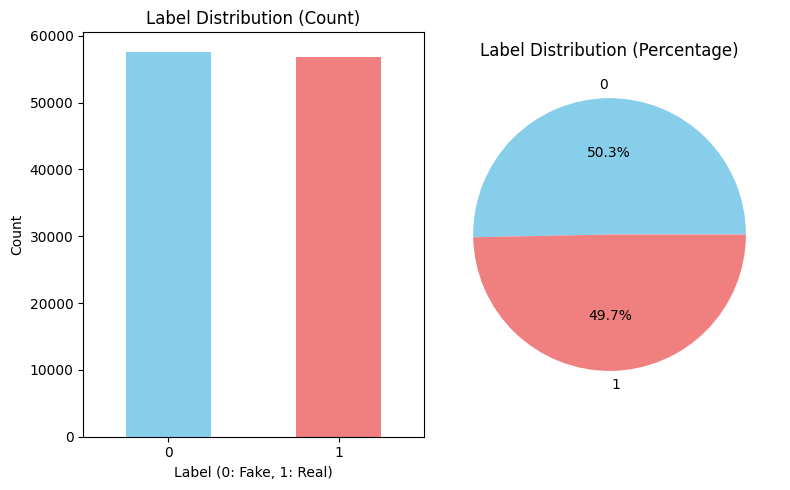


TEXT ANALYSIS

Text length statistics:
count    114552.000000
mean       2611.143035
std        2800.047377
min          36.000000
25%        1210.000000
50%        2039.000000
75%        3167.000000
max      126668.000000
Name: text_length, dtype: float64

Word count statistics:
count    114552.000000
mean        402.842962
std         434.978100
min           5.000000
25%         187.000000
50%         314.000000
75%         488.000000
max       19268.000000
Name: word_count, dtype: float64


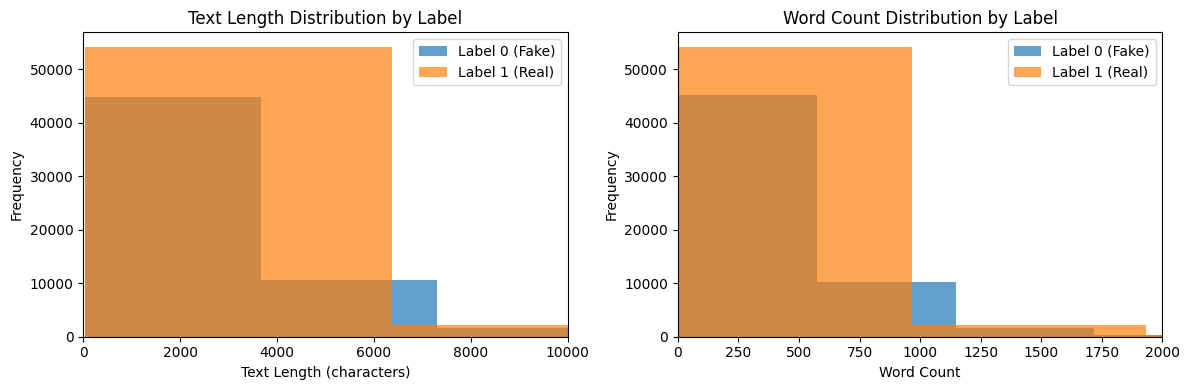


TITLE ANALYSIS
Title length statistics:
count    114552.000000
mean         69.367484
std          22.419577
min           3.000000
25%          55.000000
50%          65.000000
75%          79.000000
max         408.000000
Name: title_length, dtype: float64
Missing titles: 1

SAMPLE DATA

Sample fake news (Label = 0):
Title: donald trump sends out embarrassing new year eve message this disturbing
Text (first 200 chars): donald trump just could not wish all american happy new year and leave that instead had give shout out his enemy hater and the very dishonest fake news medium the former reality show star had just one...

Sample real news (Label = 1):
Title: you budget fight loom republican flip their fiscal script
Text (first 200 chars): washington reuters the head conservative republican faction the you congress who voted this month for huge expansion the national debt pay for tax cut called himself fiscal conservative sunday and urg...

DATA LOADING COMPLETE!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
def load_data(file_path='final_data.csv'):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Display basic information
        print("Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found!")
        return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Load and explore the data
df = load_data('final_data.csv')

if df is not None:
    # Basic data exploration
    print("\n" + "="*50)
    print("BASIC DATA EXPLORATION")
    print("="*50)
    
    # Display first few rows
    print("\nFirst 3 rows:")
    print(df.head(3))
    
    # Check data types
    print(f"\nData types:")
    print(df.dtypes)
    
    # Check for missing values
    print(f"\nMissing values:")
    print(df.isnull().sum())
    
    # Check for duplicates
    print(f"\nDuplicate rows: {df.duplicated().sum()}")
  
    # Basic statistics
    print(f"\nDataset info:")
    print(f"Total samples: {len(df)}")
    
    # Label distribution
    if 'Label' in df.columns:
        print(f"\nLabel distribution:")
        label_counts = df['Label'].value_counts()
        print(label_counts)
        print(f"\nLabel percentages:")
        print(df['Label'].value_counts(normalize=True) * 100)
        
        # Plot label distribution
        plt.figure(figsize=(8, 5))
        plt.subplot(1, 2, 1)
        df['Label'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
        plt.title('Label Distribution (Count)')
        plt.xlabel('Label (0: Fake, 1: Real)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
        plt.title('Label Distribution (Percentage)')
        plt.ylabel('')
        
        plt.tight_layout()
        plt.show()
    
    # Text length analysis
    if 'text' in df.columns:
        print(f"\n" + "="*50)
        print("TEXT ANALYSIS")
        print("="*50)
        
        # Calculate text lengths
        df['text_length'] = df['text'].astype(str).apply(len)
        df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
        
        print(f"\nText length statistics:")
        print(df['text_length'].describe())
        
        print(f"\nWord count statistics:")
        print(df['word_count'].describe())
        
        # Plot text length distribution by label
        if 'Label' in df.columns:
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            for label in df['Label'].unique():
                subset = df[df['Label'] == label]['text_length']
                plt.hist(subset, alpha=0.7, bins=20, 
                        label=f'Label {label} ({"Fake" if label == 0 else "Real"})')
            plt.xlabel('Text Length (characters)')
            plt.ylabel('Frequency')
            plt.title('Text Length Distribution by Label')
            plt.legend()
            plt.xlim(0, 10000)  # Limit x-axis for better visualization
            
            plt.subplot(1, 2, 2)
            for label in df['Label'].unique():
                subset = df[df['Label'] == label]['word_count']
                plt.hist(subset, alpha=0.7, bins=20, 
                        label=f'Label {label} ({"Fake" if label == 0 else "Real"})')
            plt.xlabel('Word Count')
            plt.ylabel('Frequency')
            plt.title('Word Count Distribution by Label')
            plt.legend()
            plt.xlim(0, 2000)  # Limit x-axis for better visualization
            
            plt.tight_layout()
            plt.show()
    
    # Title analysis (if exists)
    if 'title' in df.columns:
        print(f"\n" + "="*20)
        print("TITLE ANALYSIS")
        print("="*20)
        
        df['title_length'] = df['title'].astype(str).apply(len)
        print(f"Title length statistics:")
        print(df['title_length'].describe())
        
        # Check for missing titles
        missing_titles = df['title'].isnull().sum()
        print(f"Missing titles: {missing_titles}")
    
    # Sample data display
    print(f"\n" + "="*50)
    print("SAMPLE DATA")
    print("="*50)
    
    if len(df) > 0:
        print("\nSample fake news (Label = 0):")
        fake_sample = df[df['Label'] == 0].iloc[0]
        print(f"Title: {fake_sample.get('title', 'N/A')}")
        print(f"Text (first 200 chars): {str(fake_sample['text'])[:200]}...")
        
        if len(df[df['Label'] == 1]) > 0:
            print("\nSample real news (Label = 1):")
            real_sample = df[df['Label'] == 1].iloc[0]
            print(f"Title: {real_sample.get('title', 'N/A')}")
            print(f"Text (first 200 chars): {str(real_sample['text'])[:200]}...")

    print(f"\n" + "="*50)
    print("DATA LOADING COMPLETE!")
    print("="*50)

In [2]:
# Remove duplicate rows
df = df.drop_duplicates()

# Remove rows with missing values
df = df.dropna()

# Confirm changes
print("\nAfter cleaning:")
print(f"New shape: {df.shape}")
print(f"Remaining missing values:\n{df.isnull().sum()}")
print(f"Remaining duplicate rows: {df.duplicated().sum()}")



After cleaning:
New shape: (100329, 7)
Remaining missing values:
title           0
text            0
text_len        0
Label           0
text_length     0
word_count      0
title_length    0
dtype: int64
Remaining duplicate rows: 0


In [4]:
df.head(1)

,title,text,text_len,Label,text_length,word_count,title_length
0,donald trump sends out embarrassing new year e...,donald trump just could not wish all american ...,2283,0,2283,385,72


In [6]:
df.to_csv("final_data.csv", index=False)

In [5]:
# Remove the 'text_len' column
df = df.drop(columns=['text_len'])

# Confirm it's removed
print(df.columns)


Index(['title', 'text', 'Label', 'text_length', 'word_count', 'title_length'], dtype='object')


SHORT TEXT AND TITLE ANALYSIS

TEXT ANALYSIS:
Total text rows: 100329
Text rows with ≤ 80 characters: 438
Percentage of short texts: 0.44%

Examples of very short texts (≤ 80 characters):
  1. Length 46: 'watch openingstatment jeanine pirro april 2017'
  2. Length 66: 'have agree that this one actually pretty good rare bright spot snl'
  3. Length 70: 'russian did not hack any vote period comeyhearing tennessee march 2017'
  4. Length 79: 'trump merkel obama wiretapping least have something common wikileaks march 2017'
  5. Length 52: 'this not the first time pelosi ha lost front the mic'

TITLE ANALYSIS:
Total title rows: 100329
Title rows with ≤ 20 characters: 369
Percentage of short titles: 0.37%

Examples of very short titles (≤ 20 characters):
  1. Length 12: 'joke the day'
  2. Length 18: 'best tweet the day'
  3. Length 8: 'homepage'
  4. Length 10: 'word video'
  5. Length 19: 'what the deep state'


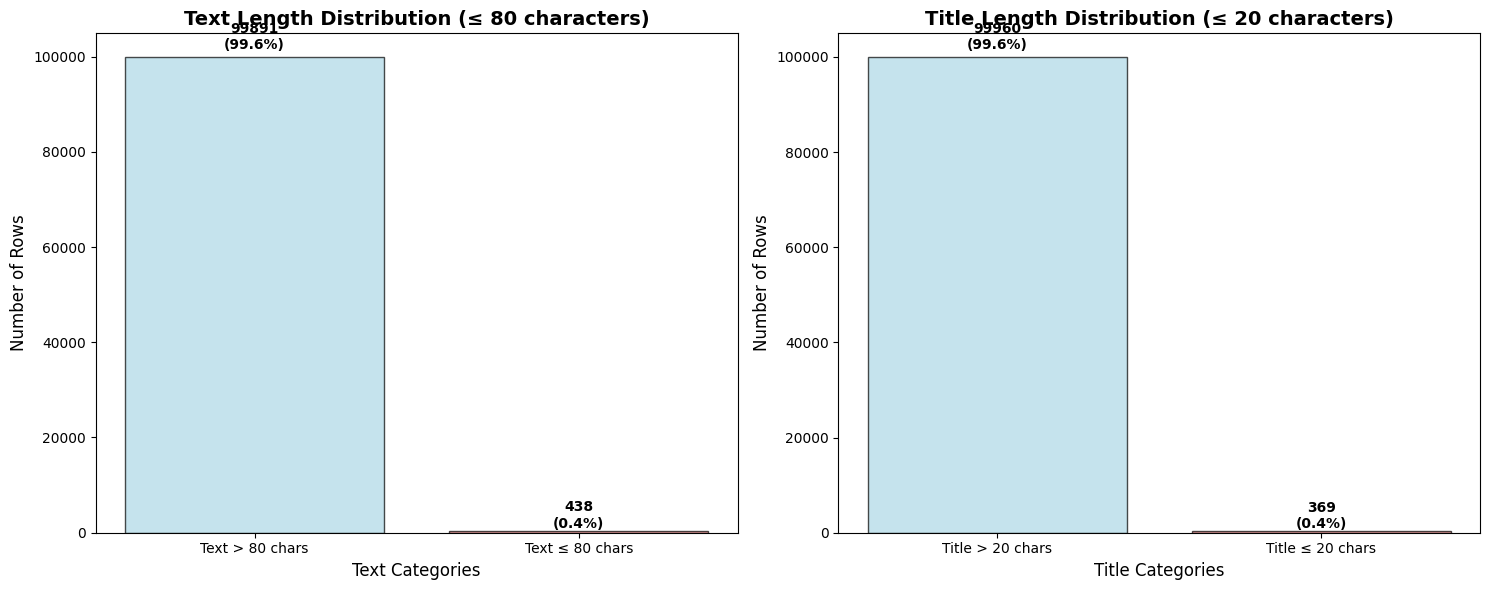


DETAILED LENGTH DISTRIBUTION

Text length distribution (0–80 characters):
  Length 36: 2 rows
  Length 38: 2 rows
  Length 41: 2 rows
  Length 43: 3 rows
  Length 44: 6 rows
  Length 45: 7 rows
  Length 46: 8 rows
  Length 47: 8 rows
  Length 48: 1 rows
  Length 49: 6 rows
  Length 50: 30 rows
  Length 51: 12 rows
  Length 52: 9 rows
  Length 53: 9 rows
  Length 54: 9 rows
  Length 55: 3 rows
  Length 56: 6 rows
  Length 57: 9 rows
  Length 58: 6 rows
  Length 59: 13 rows
  Length 60: 5 rows
  Length 61: 31 rows
  Length 62: 2 rows
  Length 63: 10 rows
  Length 64: 9 rows
  Length 65: 10 rows
  Length 66: 18 rows
  Length 67: 14 rows
  Length 68: 2 rows
  Length 69: 7 rows
  Length 70: 18 rows
  Length 71: 13 rows
  Length 72: 8 rows
  Length 73: 17 rows
  Length 74: 24 rows
  Length 75: 22 rows
  Length 76: 8 rows
  Length 77: 10 rows
  Length 78: 24 rows
  Length 79: 21 rows
  Length 80: 14 rows

Title length distribution (0–20 characters):
  Length 3: 3 rows
  Length 4: 10 rows
  L

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_short_texts(df):
    """
    Analyze and visualize short text and title frequencies

    Args:
        df: DataFrame with columns ['title', 'text', 'Label', 'text_length', 'word_count', 'title_length']
    """

    # Confirm expected columns
    expected_columns = {'title', 'text', 'Label', 'text_length', 'word_count', 'title_length'}
    if not expected_columns.issubset(df.columns):
        raise ValueError(f"DataFrame is missing required columns. Expected: {expected_columns}")

    # Count short texts and titles
    short_text_count = len(df[df['text_length'] <= 80])
    total_text_count = len(df)

    print("="*60)
    print("SHORT TEXT AND TITLE ANALYSIS")
    print("="*60)

    print(f"\nTEXT ANALYSIS:")
    print(f"Total text rows: {total_text_count}")
    print(f"Text rows with ≤ 80 characters: {short_text_count}")
    print(f"Percentage of short texts: {(short_text_count/total_text_count)*100:.2f}%")

    # Display some examples of short texts
    if short_text_count > 0:
        print(f"\nExamples of very short texts (≤ 80 characters):")
        short_texts = df[df['text_length'] <= 80]
        for i, (idx, row) in enumerate(short_texts.head(5).iterrows()):
            print(f"  {i+1}. Length {row['text_length']}: '{row['text']}'")

    # Title analysis
    short_title_count = len(df[df['title_length'] <= 20])
    total_title_count = len(df)

    print(f"\nTITLE ANALYSIS:")
    print(f"Total title rows: {total_title_count}")
    print(f"Title rows with ≤ 20 characters: {short_title_count}")
    print(f"Percentage of short titles: {(short_title_count/total_title_count)*100:.2f}%")

    # Display some examples of short titles
    if short_title_count > 0:
        print(f"\nExamples of very short titles (≤ 20 characters):")
        short_titles = df[df['title_length'] <= 20]
        for i, (idx, row) in enumerate(short_titles.head(5).iterrows()):
            print(f"  {i+1}. Length {row['title_length']}: '{row['title']}'")

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Text length bar chart
    ax1 = axes[0]
    categories = ['Text > 80 chars', 'Text ≤ 80 chars']
    counts = [total_text_count - short_text_count, short_text_count]
    colors = ['lightblue', 'lightcoral']

    bars1 = ax1.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_title('Text Length Distribution (≤ 80 characters)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Rows', fontsize=12)
    ax1.set_xlabel('Text Categories', fontsize=12)

    for bar, count in zip(bars1, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{count}\n({count/total_text_count*100:.1f}%)',
                 ha='center', va='bottom', fontweight='bold')

    # Title length bar chart
    ax2 = axes[1]
    categories = ['Title > 20 chars', 'Title ≤ 20 chars']
    counts = [total_title_count - short_title_count, short_title_count]

    bars2 = ax2.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_title('Title Length Distribution (≤ 20 characters)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Rows', fontsize=12)
    ax2.set_xlabel('Title Categories', fontsize=12)

    for bar, count in zip(bars2, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{count}\n({count/total_title_count*100:.1f}%)',
                 ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Detailed short length distribution
    print(f"\n" + "="*60)
    print("DETAILED LENGTH DISTRIBUTION")
    print("="*60)

    print(f"\nText length distribution (0–80 characters):")
    short_range = df[df['text_length'] <= 80]['text_length'].value_counts().sort_index()
    if len(short_range) > 0:
        for length, count in short_range.items():
            print(f"  Length {length}: {count} rows")
    else:
        print("  No texts with ≤ 80 characters found")

    print(f"\nTitle length distribution (0–20 characters):")
    short_title_range = df[df['title_length'] <= 20]['title_length'].value_counts().sort_index()
    if len(short_title_range) > 0:
        for length, count in short_title_range.items():
            print(f"  Length {length}: {count} rows")
    else:
        print("  No titles with ≤ 20 characters found")

    # Return summary
    summary = {
        'total_rows': total_text_count,
        'short_texts': short_text_count,
        'short_text_percentage': (short_text_count / total_text_count) * 100,
        'short_titles': short_title_count,
        'short_title_percentage': (short_title_count / total_title_count) * 100
    }

    return summary

# Run analysis if df exists
if 'df' in locals() or 'df' in globals():
    summary_stats = analyze_short_texts(df)

    print(f"\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Dataset contains {summary_stats['total_rows']} total rows")
    print(f"Short texts (≤ 80 chars): {summary_stats['short_texts']} ({summary_stats['short_text_percentage']:.2f}%)")
    print(f"Short titles (≤ 20 chars): {summary_stats['short_titles']} ({summary_stats['short_title_percentage']:.2f}%)")
else:
    print("Please load the dataset first using: df = pd.read_csv('final_data.csv')")


In [8]:
# Remove short texts (text_length ≤ 80) and short titles (title_length ≤ 20)
df = df[(df['text_length'] > 80) & (df['title_length'] > 20)]

# Confirm removal
print(f"Updated dataset shape: {df.shape}")
print(f"Remaining rows: {len(df)}")


Updated dataset shape: (99531, 6)
Remaining rows: 99531


In [9]:
df.to_csv("final_data.csv", index=False)